
    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.


In [1]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load EPEACS module
from epeacs.agents.epeacs import EPEACS, Configuration

from epeacs.agents.epeacs.utils.Plotting_wrapper import \
    parse_metrics_to_df, \
    plot_performance

from epeacs.metrics import \
    _maze_metrics, \
    _how_many_peps_match_non_aliased_states, \
    _mean_reliable_classifier_specificity, \
    _when_full_knowledge_is_achieved, \
    _state_of_population, \
    _enhanced_effect_error

# Load environments
import gym
import my_mazes

# Agent - EPEACS

## Common parameters

In [2]:
RANDOM_ATTRIBUTE_LENGTH = 0
CLASSIFIER_LENGTH = 8 + RANDOM_ATTRIBUTE_LENGTH
NUMBER_OF_POSSIBLE_ACTIONS = 8

MAZE = "Woods102-v0"

NUMBER_OF_EXPLORE_TRIALS = 1000
METRICS_TRIAL_FREQUENCY_EXPLORE = 20
BETA_ALP = 0.05
BETA_RL = 0.05
BETA_PEP = 0.01
EPSILON = 0.8

DO_GA = False
ENABLE_PEP = True

SLIPPERY_PROB = 0.

NUMBER_OF_EXPLOIT_TRIALS_NO_RL = 500
BETA_EXPLOIT_NO_RL = 0.00

NUMBER_OF_EXPLOIT_TRIALS_RL_START = 500
BETA_EXPLOIT_RL_START = 0.05

NUMBER_OF_EXPLOIT_TRIALS_RL = 500
BETA_EXPLOIT_RL = 0.05

LENGTH_OF_BEHAVIORAL_SEQUENCES = 1

## Environment - Maze

In [3]:
# Initialize environment
maze = gym.make(MAZE)
# Set up probability to do a random action
maze.env.set_prob_slippery(SLIPPERY_PROB)
# Set up random attribute length
maze.env.set_random_attribute_length(RANDOM_ATTRIBUTE_LENGTH)
# Reset it, by putting an agent into random position
maze.reset()
# Render the state in ASCII
maze.render('aliasing_human')
# Get environmental state transitions
#maze.env.get_theoritical_probabilities()


■ ■ ■ ■ ■ ■ ■
■ ■ ■ $ ■ ■ ■
■ □ ■ □ ■ □ ■
■ ■ ■ ■ ■ ■ ■
■ □ ■ □ ■ □ ■
■ ■ ■ ■ ■ ■ ■
■ □ ■ □ ■ □ ■
■ ■ ■ ■ ■ ■ ■
■ □ ■ □ ■ □ ■
■ ■ ■ $ ■ A ■
■ ■ ■ ■ ■ ■ ■


## Training of EPEACS - Exploration

In [4]:
%%time

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=METRICS_TRIAL_FREQUENCY_EXPLORE,
    do_pep=ENABLE_PEP,
    do_ga=DO_GA,
    beta_alp=BETA_ALP,
    beta_rl=BETA_RL,
    beta_pep=BETA_PEP,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_explore = EPEACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, NUMBER_OF_EXPLORE_TRIALS)

CPU times: user 57.7 s, sys: 340 ms, total: 58 s
Wall time: 1min 2s


### Performance

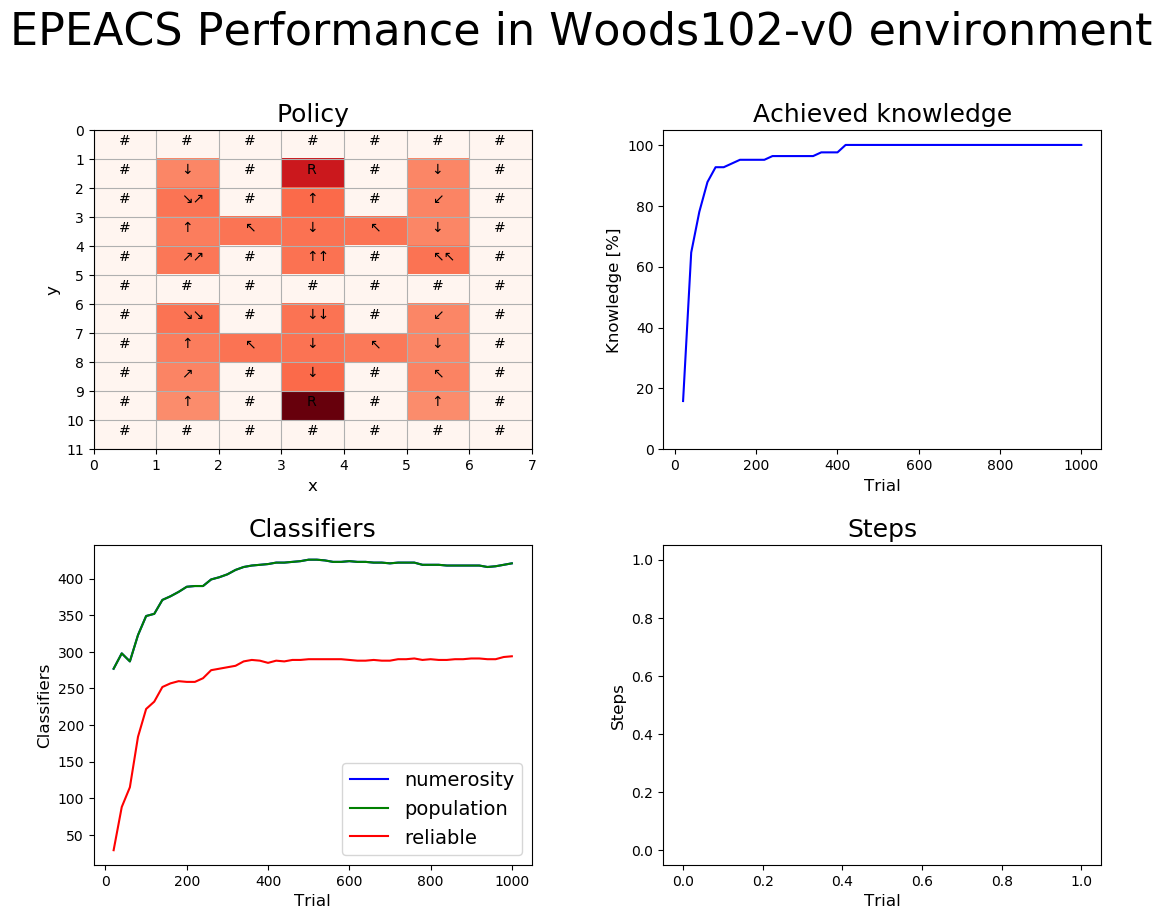

In [5]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, None, None)
plot_performance(agent_explore, maze, metrics_df, cfg_explore, MAZE, metrics_trial_frequency_explore, None)

In [6]:
print(_maze_metrics(population_explore, maze))

first_trial, stable_trial, last_trial = _when_full_knowledge_is_achieved(metrics_explore)

print("Full knowledge was achieved at trials ", first_trial, ", was stable at ", stable_trial, 
        " and the last time it was achieved at ", last_trial)

print("There are ", _how_many_peps_match_non_aliased_states(population_explore, maze),
      " enhanced classifer(s) that match a non-aliased states.")

print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, maze))

print(_state_of_population(metrics_explore, last_trial, METRICS_TRIAL_FREQUENCY_EXPLORE))

old_error, new_error = _enhanced_effect_error(population_explore, maze, CLASSIFIER_LENGTH, RANDOM_ATTRIBUTE_LENGTH)
print("Accumulated Error on PEP Probabilities : old->", old_error, "% new->", new_error, "%")

{'knowledge': 100.0, 'population': 421, 'numerosity': 421, 'reliable': 294}
Full knowledge was achieved at trials  420 , was stable at  420  and the last time it was achieved at  1000
There are  0  enhanced classifer(s) that match a non-aliased states.
Mean reliable population specifity is  0.5884353741496599
{'trial': 1000, 'steps_in_trial': 99, 'reward': 0, 'knowledge': 100.0, 'population': 421, 'numerosity': 421, 'reliable': 294}
Accumulated Error on PEP Probabilities : old-> 1.1346475465843227 % new-> 1.1713981146172905 %


In [7]:
population_explore.sort(key=lambda cl: -cl.exp * cl.num)
population_explore_to_display = [(cl.condition, cl.action, cl.effect, cl.exp, cl.num) for cl in population_explore
    if cl.is_reliable() and cl.is_enhanced()]
for cl in population_explore_to_display:
    print(cl)
    print(cl[2].print_detailled_counter())
    print("\n")

(1000100#, 3, {0:100.00% (100.00%)}{1:51.39% (52.00%), 0:48.61% (48.00%)}{1:100.00% (100.00%)}{1:100.00% (100.00%)}{1:39.64% (44.24%), 0:32.98% (29.99%), 9:27.38% (25.77%)}{1:100.00% (100.00%)}{1:100.00% (100.00%)}#, 875, 1)
01110110:#262, 00119110:#225, 00111110:#195, 01111110:#192


(1#001000, 5, {0:100.00% (100.00%)}#{1:100.00% (100.00%)}{1:100.00% (100.00%)}{1:35.87% (47.62%), 0:34.09% (27.94%), 9:30.03% (24.44%)}{1:100.00% (100.00%)}{1:100.00% (100.00%)}{1:50.31% (52.26%), 0:49.69% (47.74%)}, 796, 1)
00111110:#186, 00119110:#194, 00111111:#193, 00110111:#222


(#10#0#01, 4, #{0:100.00% (100.00%)}{1:100.00% (100.00%)}#{1:51.65% (48.07%), 9:48.35% (51.93%)}#{1:100.00% (100.00%)}{0:100.00% (100.00%)}, 648, 1)
00119110:#336, 00111110:#311


(0#01#10#, 0, {1:50.14% (48.09%), 9:49.86% (51.91%)}#{1:100.00% (100.00%)}{0:100.00% (100.00%)}#{0:100.00% (100.00%)}{1:100.00% (100.00%)}#, 575, 1)
11100011:#276, 91100011:#298


(#1##1##1, 0, #{0:50.38% (43.21%), 1:49.62% (56.79%)}##{0:100.00% (1

In [8]:
agent_explore.get_pai_states_memory()

[('1', '0', '0', '0', '1', '0', '0', '0'),
 ('0', '1', '1', '1', '1', '1', '1', '1'),
 ('0', '1', '0', '1', '0', '1', '0', '1'),
 ('0', '1', '0', '1', '0', '1', '1', '1'),
 ('1', '1', '1', '1', '0', '1', '1', '1'),
 ('0', '1', '1', '1', '0', '1', '0', '1')]

## Training of EPEACS - Exploitation

In [9]:
%%time

cfg_exploit_no_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_NO_RL,
    beta_pep=BETA_PEP,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_no_rl = EPEACS(cfg_exploit_no_rl, population_explore)
#agent_exploit_no_rl.zip_population()
population_exploit_no_rl, metrics_exploit_no_rl = agent_exploit_no_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_NO_RL)

CPU times: user 13.5 s, sys: 9.15 ms, total: 13.5 s
Wall time: 13.6 s


In [10]:
%%time

cfg_exploit_rl_start = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_RL_START,
    beta_pep=BETA_PEP,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_rl_start = EPEACS(cfg_exploit_rl_start, population_exploit_no_rl)
#agent_exploit_rl_start.zip_population()
population_exploit_rl_start, metrics_exploit_rl_start = agent_exploit_rl_start.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL_START)

CPU times: user 13.6 s, sys: 9.36 ms, total: 13.6 s
Wall time: 13.6 s


In [11]:
%%time

cfg_exploit_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_RL,
    beta_pep=BETA_PEP,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_rl = EPEACS(cfg_exploit_rl, population_exploit_rl_start)
#agent_exploit_rl.zip_population()
population_exploit_rl, metrics_exploit_rl = agent_exploit_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL)

CPU times: user 13.5 s, sys: 8.33 ms, total: 13.6 s
Wall time: 13.6 s


### Performance

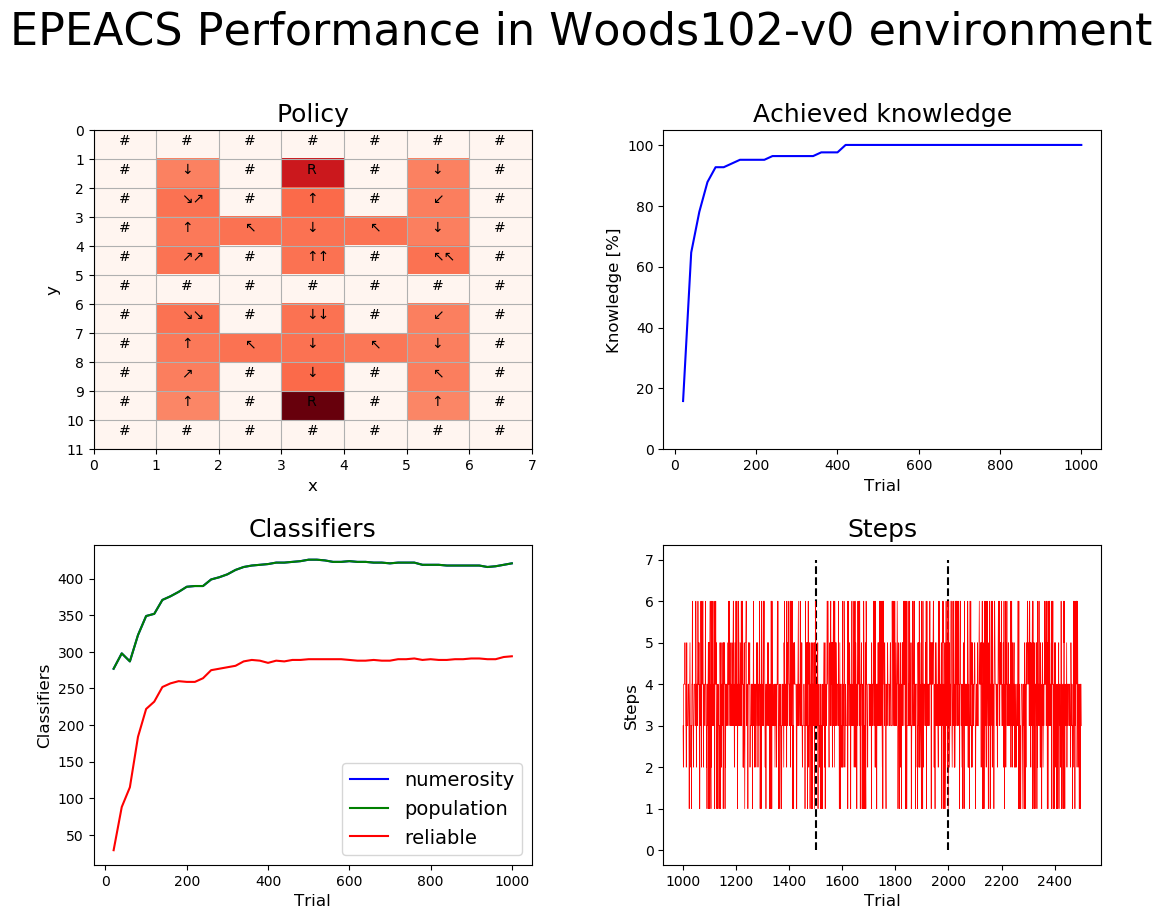

In [12]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency
metrics_trial_frequency_exploit = 1

metrics_exploit = metrics_exploit_no_rl.copy()
for idx, item in enumerate(metrics_exploit_rl_start):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL
    metrics_exploit.append(tmp)
for idx, item in enumerate(metrics_exploit_rl):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL + NUMBER_OF_EXPLOIT_TRIALS_RL_START
    metrics_exploit.append(tmp)

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, metrics_exploit, metrics_trial_frequency_exploit)
plot_performance(agent_exploit_rl, maze, metrics_df, cfg_exploit_rl, MAZE, metrics_trial_frequency_explore, [NUMBER_OF_EXPLOIT_TRIALS_NO_RL,NUMBER_OF_EXPLOIT_TRIALS_RL_START,NUMBER_OF_EXPLOIT_TRIALS_RL])

In [13]:
avg_step_explore = 0
for trial in metrics_explore:
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS / metrics_trial_frequency_explore
print("Average number of steps to solve the maze is ",avg_step_explore,
      " for a total of ", NUMBER_OF_EXPLORE_TRIALS, " trials in EXPLORATION")

avg_step_exploit_no_rl = 0
for trial in metrics_exploit_no_rl:
    avg_step_exploit_no_rl += trial['steps_in_trial']
avg_step_exploit_no_rl /= NUMBER_OF_EXPLOIT_TRIALS_NO_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_no_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_NO_RL, " trials in EXPLOITATION without Reinforcement Module")

avg_step_exploit_rl_start = 0
for trial in metrics_exploit_rl_start:
    avg_step_exploit_rl_start += trial['steps_in_trial']
avg_step_exploit_rl_start /= NUMBER_OF_EXPLOIT_TRIALS_RL_START
print("Average number of steps to solve the maze is ",avg_step_exploit_rl_start,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL_START, " trials in EXPLOITATION starting Reinforcement Module")

avg_step_exploit_rl = 0
for trial in metrics_exploit_rl:
    avg_step_exploit_rl += trial['steps_in_trial']
avg_step_exploit_rl /= NUMBER_OF_EXPLOIT_TRIALS_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL, " trials in EXPLOITATION with Reinforcement Module")

print(_maze_metrics(population_explore, maze))
print(_maze_metrics(population_exploit_no_rl, maze))
print(_maze_metrics(population_exploit_rl_start, maze))
print(_maze_metrics(population_exploit_rl, maze))

Average number of steps to solve the maze is  30.6  for a total of  1000  trials in EXPLORATION
Average number of steps to solve the maze is  3.682  for a total of  500  trials in EXPLOITATION without Reinforcement Module
Average number of steps to solve the maze is  3.734  for a total of  500  trials in EXPLOITATION starting Reinforcement Module
Average number of steps to solve the maze is  3.734  for a total of  500  trials in EXPLOITATION with Reinforcement Module
{'knowledge': 100.0, 'population': 421, 'numerosity': 421, 'reliable': 294}
{'knowledge': 100.0, 'population': 421, 'numerosity': 421, 'reliable': 294}
{'knowledge': 100.0, 'population': 421, 'numerosity': 421, 'reliable': 294}
{'knowledge': 100.0, 'population': 421, 'numerosity': 421, 'reliable': 294}


In [14]:
population_exploit_rl.sort(key=lambda cl: -cl.q)
population_exploit_rl_to_display = [(cl.condition, cl.action, cl.behavioral_sequence, cl.effect, cl.mark, cl.q, cl.exp, cl.ee) 
    for cl in population_exploit_rl if cl.behavioral_sequence]
for cl in population_exploit_rl_to_display:
    print(cl)
    print("\n")

(#01#1#10, 0, [0], 91#000#1, empty, 0.9999999999999989, 359, False)


(01110110, 7, [5], #0##9###, empty, 0.9999999997798973, 10, False)


(011#0111, 3, [3], #0#11##0, empty, 0.9999999995090925, 49, False)


(0111011#, 7, [1], 1####0#1, empty, 0.9999999994732761, 52, False)


(0111011#, 7, [7], 1##0#0#1, empty, 0.9999999990739739, 50, False)


(011#0111, 3, [5], #0#11###, empty, 0.9999999990437028, 38, False)


(1#10#01#, 4, [4], 00#191#0, empty, 0.9999999947031131, 119, False)


(011#0111, 3, [1], 9####0##, empty, 0.999999994529963, 79, False)


(0111011#, 7, [2], ######01, empty, 0.9999999608438402, 48, False)


(01110#11, 5, [5], #0##11#0, empty, 0.9999999548211287, 39, False)


(0#110111, 1, [1], 11#0#0##, empty, 0.9999999197084916, 39, False)


(011#0111, 3, [6], ##01####, empty, 0.9999999081261393, 36, False)


(11100111, 3, [3], 00#19##0, empty, 0.9999998504991662, 103, False)


(011#0111, 3, [2], ##01##0#, empty, 0.9999996687912248, 38, False)


(01111110, 7, [7], 9##000#1, emp